Had some serious memory management issues using the default Kaggle Kernels so I cobbled together a few tricks people were doing in other kernels to try and reduce the required memory for these datasets.

In [1]:
import os
import gc
import random
from pathlib import Path
import multiprocessing
from pprint import pprint, pformat

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import fastai
from fastai import metrics
from fastai.tabular import FillMissing, Categorify, Normalize, DatasetType
from fastai.tabular import TabularDataBunch, tabular_learner, TabularList, load_learner
print(f"Fastai version: {fastai.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

INPUT = Path('/kaggle/input/ieee-fraud-detection')

Fastai version: 1.0.57
Pandas version: 0.25.1
Numpy version: 1.16.4


In [2]:
def basic_mem_reduction(df):
    """Casts each column to the smallest dtype it can without throwing an error."""
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    df = (df.pipe(all_float_to_int)
          .pipe(downcast_all, "float")
          .pipe(downcast_all, "integer")
          .pipe(downcast_all, target_type="unsigned", inital_type="integer"))
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    diff = end_mem - start_mem
    pct = int(diff/start_mem * 100)
    print(f"Saved {diff}Mb of Memory: {pct}%")
    return df


def float_to_int(series):
    try:
        int_ser = series.astype(int)
        if (series == int_ser).all():
            return int_ser
        else:
            return series
    except (ValueError, AssertionError):
        return series


def all_float_to_int(df):
    func = float_to_int
    condition = lambda x: list(x.select_dtypes(include=["float"]).columns)
    return multi_assign(df, func, condition)


def multi_assign(df, func, condition):
    """
    Applies function <func> to every column in <df> which satisfies <condition>
    """
    return df.assign(**{col: func(df[col]) for col in condition(df)})


def downcast_all(df, target_type, inital_type=None):
    """
    :param df: target dataframe
    :param target_type: 'float', 'integer' or 'unisgned'
    :param inital_type: same as target_type
    :return: downcasted dataframe
    """
    if inital_type is None:
        inital_type = target_type
    transform = lambda x: pd.to_numeric(x, downcast=target_type)
    condition = lambda x: list(x.select_dtypes(include=[inital_type]).columns)
    return multi_assign(df, transform, condition)


In [3]:
# Used for testing, is None in final verison
nrows = None

In [4]:
train_identity = pd.read_csv(INPUT / 'train_identity.csv', nrows=nrows)
train_transaction = pd.read_csv(INPUT / 'train_transaction.csv', nrows=nrows)

In [5]:
test_identity = pd.read_csv(INPUT / 'test_identity.csv', nrows=nrows)
test_transaction = pd.read_csv(INPUT / 'test_transaction.csv', nrows=nrows)

In [6]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
train_identity.shape, train_transaction.shape, test_identity.shape, test_transaction.shape

((144233, 41), (590540, 394), (141907, 41), (506691, 393))

In [8]:
train_identity = basic_mem_reduction(train_identity)
train_transaction = basic_mem_reduction(train_transaction)
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left', left_index=True, right_index=True)

del train_identity, train_transaction
gc.collect()

Saved -13.617579460144043Mb of Memory: -8%
Saved -875.7493019104004Mb of Memory: -41%


0

In [9]:
test_identity = basic_mem_reduction(test_identity)
test_transaction = basic_mem_reduction(test_transaction)
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left', left_index=True, right_index=True)

del test_identity, test_transaction
gc.collect()

Saved -13.39797306060791Mb of Memory: -8%
Saved -778.4645090103149Mb of Memory: -42%


0

In [10]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [11]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [12]:
test.columns, train.columns

(Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
        'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
        ...
        'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
        'DeviceType', 'DeviceInfo'],
       dtype='object', length=433),
 Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
        'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
        ...
        'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
        'DeviceType', 'DeviceInfo'],
       dtype='object', length=434))

The test and training sets actually dont have the same columns. 'id_12' in train is 'id-12' in test, for example. So we standardize those as well

In [13]:
renames = {c: c.replace('-', '_') for c in test.columns if '-' in c}
renames

{'id-01': 'id_01',
 'id-02': 'id_02',
 'id-03': 'id_03',
 'id-04': 'id_04',
 'id-05': 'id_05',
 'id-06': 'id_06',
 'id-07': 'id_07',
 'id-08': 'id_08',
 'id-09': 'id_09',
 'id-10': 'id_10',
 'id-11': 'id_11',
 'id-12': 'id_12',
 'id-13': 'id_13',
 'id-14': 'id_14',
 'id-15': 'id_15',
 'id-16': 'id_16',
 'id-17': 'id_17',
 'id-18': 'id_18',
 'id-19': 'id_19',
 'id-20': 'id_20',
 'id-21': 'id_21',
 'id-22': 'id_22',
 'id-23': 'id_23',
 'id-24': 'id_24',
 'id-25': 'id_25',
 'id-26': 'id_26',
 'id-27': 'id_27',
 'id-28': 'id_28',
 'id-29': 'id_29',
 'id-30': 'id_30',
 'id-31': 'id_31',
 'id-32': 'id_32',
 'id-33': 'id_33',
 'id-34': 'id_34',
 'id-35': 'id_35',
 'id-36': 'id_36',
 'id-37': 'id_37',
 'id-38': 'id_38'}

In [14]:
test = test.rename(columns=renames)
test.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

Make sure all the columns are identical now

In [15]:
all([list(test.columns) == [x for x in train.columns if x != 'isFraud']])

True

In [16]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

# TEST WITH FASTAI
I had issues with the cleaned data not working properly with fastai because of the pandas multi-indexes, which it didnt know how to handle. If the lr_finder works properly, that's a passing test.

In [17]:
pct = 0.2
indxs = list(train.index)
wanted_num = int(len(indxs) * pct)
valid_idx = [random.randrange(len(indxs)) for x in range(wanted_num)]
print(f"Getting {pct*100}% of indexes: {wanted_num}/{len(indxs)} = {len(valid_idx)}")

Getting 20.0% of indexes: 118108/590540 = 118108


In [18]:
def get_cat_names(df):
    cards = [f"card{i}" for i in range(1, 7)]
    matches = [f"M{i}" for i in range(1, 10)]
    trx_cats = ["ProductCD", "addr1", "addr2", "P_emaildomain", "R_emaildomain", *cards, *matches]
    ids = [f"id_{i}" for i in range(12, 39)]
    id_cats = ["DeviceType", "DeviceInfo", *ids]
    cat_names = trx_cats + id_cats
    cat_names = [x for x in cat_names if x in df.columns]
    cont_names = [x for x in df.columns if x not in cat_names]
    return cat_names, cont_names

In [19]:
cat_names, cont_names = get_cat_names(train)

In [20]:
for col in train.columns:
    type_ = str(train[col].dtype)
    if col in cat_names:
        train[col] = train[col].astype('category')
        continue
    if 'float' not in type_ and 'int' not in type_:
        continue
train['isFraud'] = train['isFraud'].astype('category')

In [21]:
cat_names, cont_names = get_cat_names(train)
procs = [FillMissing, Categorify, Normalize]

In [22]:
valid_idx, procs, cat_names

([116739,
  26225,
  288389,
  256787,
  234053,
  146316,
  107473,
  571858,
  91161,
  442417,
  33326,
  31244,
  98246,
  229258,
  243962,
  529903,
  27824,
  588508,
  208496,
  571412,
  439898,
  231148,
  471029,
  291704,
  6814,
  167414,
  443143,
  356778,
  291369,
  163032,
  225772,
  352944,
  107175,
  97251,
  398382,
  101414,
  376417,
  360663,
  277370,
  45561,
  481741,
  562275,
  130889,
  396922,
  82627,
  578856,
  307419,
  379201,
  201629,
  72933,
  48050,
  238968,
  303445,
  83667,
  244098,
  105907,
  398591,
  291476,
  475435,
  382554,
  170555,
  388162,
  372528,
  219684,
  279946,
  74870,
  179451,
  560086,
  256702,
  171339,
  484714,
  397887,
  283060,
  584004,
  230283,
  340035,
  58655,
  240174,
  33659,
  330776,
  420651,
  280746,
  69403,
  221231,
  329963,
  222955,
  523481,
  414850,
  481141,
  149811,
  277746,
  146413,
  258607,
  588637,
  565158,
  275504,
  449245,
  418801,
  379580,
  229974,
  145051,
  534277

In [23]:

data = TabularDataBunch.from_df('/models', train, 'isFraud', valid_idx=valid_idx, procs=procs, cat_names=cat_names)

In [24]:
learner = tabular_learner(data, layers=[400, 100], emb_drop=0.2, ps=[0.2, 0.2], metrics=[metrics.AUROC()])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


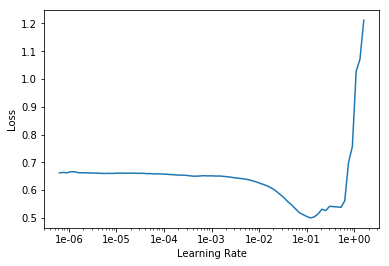

In [25]:
learner.lr_find()
learner.recorder.plot()

In [26]:
learner.validate()

[0.6375267, tensor(0.5494)]

It works!